 ## 1. Make classification data and get it ready

In [1]:
import sklearn
import numpy as np
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import torch

torch.__version__ 

'2.4.0'

In [2]:
# make 1000 samples
X, y = datasets.make_circles(n_samples=1000, noise=0.1, factor=0.2, random_state=42) # noise is the standard deviation of the guassian noise added to the data and factor is the ratio of the inner and outer circle

In [3]:
print(f"First 5 samples: {X[:5]}")
# print(y)

First 5 samples: [[ 0.13287946  0.12819341]
 [-0.08670428  0.10969125]
 [-0.27075685  0.26845145]
 [-0.26218018  0.0777025 ]
 [ 0.4540887  -0.89046586]]


In [4]:
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head()

,X1,X2,label
0,0.132879,0.128193,1
1,-0.086704,0.109691,1
2,-0.270757,0.268451,1
3,-0.262180,0.077703,1
4,0.454089,-0.890466,0


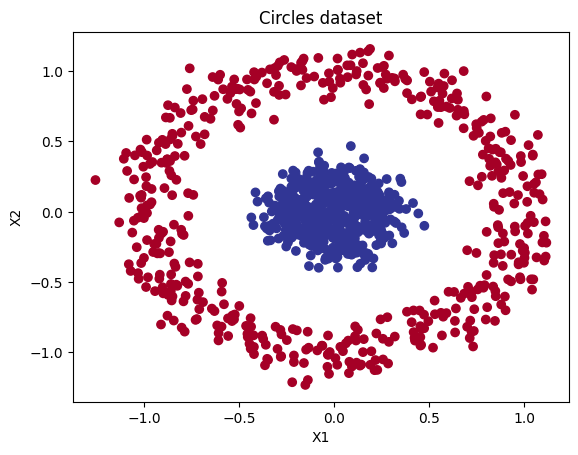

In [5]:
# Visualize the data
plt.scatter(circles["X1"], circles["X2"], c=y, cmap=plt.cm.RdYlBu)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Circles dataset")
plt.show()

### 1.1 Check input and output shape

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Turn the data into a tensor format that can be used for classification

In [7]:
# Turn into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [8]:
X[:5], y[:5]

(tensor([[ 0.1329,  0.1282],
         [-0.0867,  0.1097],
         [-0.2708,  0.2685],
         [-0.2622,  0.0777],
         [ 0.4541, -0.8905]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 2. Make a model
Let's build a model which can classify blue and red points.

We need to do the followings:
- Setup CUDA for GPU acceleration
- Define a model
- Define a loss function
- Define an optimizer
- Train the model

In [10]:
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# Construct the model

class CircleModel_V0(nn.Module):
    def __init__(self):
        super(CircleModel_V0, self).__init__() # It is used to call the __init__() method of the parent class (nn.Module).
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 1)
        # self.fc12 = nn.Sequential( # Sequential is used to create a sequence of layers
        #     nn.Linear(2, 5),
        #     nn.Linear(5, 1)
        # )

    def forward(self, X):
        X = self.fc1(X)
        X = self.fc2(X)
        return X

In [12]:
torch.manual_seed(42)
model_0 = CircleModel_V0().to(device)
model_0.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('fc1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('fc2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('fc2.bias', tensor([-0.2060], device='cuda:0'))])

In [13]:
# Make predictions
untrained_preds = model_0(X_train[:10].to(device))
untrained_preds

tensor([[-0.1366],
        [-0.1606],
        [-0.1927],
        [-0.1967],
        [-0.1343],
        [-0.2074],
        [-0.1354],
        [-0.1354],
        [-0.1284],
        [-0.1389]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 2.1 Setup Loss function and Optimizer
Which loss function and optimizer should we use?

For regression, we used Mean Squared Error loss and Adam optimizer.
For classification, we can use Cross Entropy loss and Adam optimizer.

Logit Layers: The output of the model is a logit layer. The logit layer is a linear layer that outputs the raw score for each class. The logit layer is the last layer of the model. It feeds into the softmax layer, which converts the raw scores into probabilities.

In [14]:
loss = torch.nn.BCEWithLogitsLoss() # It combines a sigmoid activation function and a binary cross entropy loss in one function
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [15]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # eq() is used to compare the elements of two tensors and returns a new tensor of the same shape as the input tensors
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train the model
Let's train the model and see how well it can classify blue and red points.

1. Forward pass: Compute predicted y by passing x to the model
2. Compute and print loss
3. Zero gradients, backward pass, update weights (optimizer.step)


### 3.1 Gowing from true logits to predictions -> prediction labe

Our model is currently outputting logits. To convert these logits to predictions, we'll:
- Apply the sigmoid function to the logits
- Round the values to the nearest integer (0 or 1)


In [19]:
# View the first 5 outputs of the forward pass on the test set
model_0.eval() # It sets the model to evaluation mode which turns off dropout and batch normalization
with torch.inference_mode():
    y_logits = model_0(X_test[:5].to(device))
y_logits

tensor([[-0.1408],
        [-0.0949],
        [-0.1512],
        [-0.1015],
        [-0.1650]], device='cuda:0')

In [20]:
# Use sigmoid activation function to get the probabilities
y_pred_probs = torch.sigmoid(y_logits)

In [21]:
print(f"Predicted probabilities: {y_pred_probs}")

Predicted probabilities: tensor([[0.4649],
        [0.4763],
        [0.4623],
        [0.4746],
        [0.4588]], device='cuda:0')


We need the perform a range style rounding

* If the value is greater than 0.5, we'll round it to 1
* If the value is less than 0.5, we'll round it to 0

In [22]:
# Find the predicted labels
y_pred = torch.round(y_pred_probs)
y_pred_full = torch.round(torch.sigmoid(model_0(X_test.to(device))))

print(f"Predicted labels: {y_pred}")
print(f"Full predicted labels: {y_pred_full}")


Predicted labels: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')
Full predicted labels: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
   

### 3.2 Building the training loop and testing loop

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42) # It is used to set the seed for generating random numbers on all GPUs

epochs = 1000
losses = []
train_accs = []
test_accs = []

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze() # Squeeze is used to remove the dimensions of size 1 from the tensor
    y_pred = torch.round(torch.sigmoid(y_logits)) # Sigmoid activation function to get the probabilities

    # Calculate the loss
    train_loss = loss(y_logits, y_train)

    # Backward pass
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Calculate the accuracy
    train_acc = accuracy(y_train, y_pred)

    # Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_loss = loss(test_logits, y_test)
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_acc = accuracy(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} => Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")

Epoch 0 => Train loss: 0.6956, Train acc: 50.00, Test loss: 0.6968, Test acc: 50.00
Epoch 100 => Train loss: 0.6928, Train acc: 52.00, Test loss: 0.6960, Test acc: 49.00
Epoch 200 => Train loss: 0.6928, Train acc: 52.38, Test loss: 0.6960, Test acc: 49.50
Epoch 300 => Train loss: 0.6928, Train acc: 52.38, Test loss: 0.6960, Test acc: 49.50
Epoch 400 => Train loss: 0.6928, Train acc: 52.38, Test loss: 0.6960, Test acc: 49.50
Epoch 500 => Train loss: 0.6928, Train acc: 52.38, Test loss: 0.6960, Test acc: 49.50
Epoch 600 => Train loss: 0.6928, Train acc: 52.38, Test loss: 0.6960, Test acc: 49.50
Epoch 700 => Train loss: 0.6928, Train acc: 52.38, Test loss: 0.6960, Test acc: 49.50
Epoch 800 => Train loss: 0.6928, Train acc: 52.38, Test loss: 0.6960, Test acc: 49.50
Epoch 900 => Train loss: 0.6928, Train acc: 52.38, Test loss: 0.6960, Test acc: 49.50


### Plot the data and the model's predictions